# 04: Cluster evaluation and interpretation

**Author:** Grace Akatsu

**Class:** CPBS 7602, Fall 2025

---
## Overview
This notebook evaluates and interprets the k-means and DBSCAN clustering performed in notebooks 02 and 03.

## Table of Contents
*   [Import libraries](#import_libraries)
*   [Set paths and seed](#set_paths)
*   [Read in data](#read_data)
*   [Cluster evaluation: internal metrics](#internal)
    *   [Adjusted Rand Index (ARI)](#ari)
    *   [Normalized Mutual Information (NMI)](#nmi)
*   [Cluster evaluation: external metrics](#external)
    *   [Silhouette coefficient](#silhouette)
    *   [Calinski–Harabasz Index (Variance Ratio Criterion)](#calinski)
    *   [Davies–Bouldin Index](#davies)
*   [Cluster evaluation: summary](#cluster_summary)
*   [Most important features (genes) driving clustering](#cluster_genes)
*   [Most important features (genes) per tissue](#tissue_genes)
*   [Most important features (genes) driving clustering and per tissue](#cluster_vs_tissue)


---

## Import libraries <a class="anchor" id="import_libraries"></a>

In [50]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import normalized_mutual_info_score as nmi 
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.feature_selection import f_classif
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import seaborn as sns

## Set paths and seed <a class="anchor" id="set_paths"></a>

In [51]:
DATA_FILE = "/Users/akatsug/OneDrive - The University of Colorado Denver/CPBS_7602_big_data_in_biomedical_informatics/assignment01/clean_data/gtex_top10_tissues_top5000_variable_genes_standardized.csv"
K_MEANS_OUTPUTS = "/Users/akatsug/OneDrive - The University of Colorado Denver/CPBS_7602_big_data_in_biomedical_informatics/assignment01/k_means_outputs"
DBSCAN_OUTPUTS = "/Users/akatsug/OneDrive - The University of Colorado Denver/CPBS_7602_big_data_in_biomedical_informatics/assignment01/DBSCAN_outputs"

In [52]:
np.random.seed(0)

## Read in data <a class="anchor" id="read_data"></a>

In [53]:
data_raw = pd.read_csv(
    DATA_FILE,
    index_col="SAMPID"
)

data_raw.head()

,Tissue,ENSG00000244734.3,ENSG00000188536.12,ENSG00000198804.2,ENSG00000198938.2,ENSG00000163220.10,ENSG00000198899.2,ENSG00000198886.2,ENSG00000198712.1,ENSG00000143632.14,...,ENSG00000261236.7,ENSG00000188112.8,ENSG00000170035.15,ENSG00000024862.17,ENSG00000213619.9,ENSG00000176087.14,ENSG00000115596.3,ENSG00000138386.16,ENSG00000182872.15,ENSG00000070669.16
SAMPID,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,-0.317682,-0.320624,-0.822484,-0.623593,-0.278153,-0.845429,-0.920044,-0.944370,-0.332153,...,-0.259958,0.087855,0.714803,0.769940,0.143898,-0.476630,-0.245165,-0.547999,-0.027921,-0.037272
GTEX-1117F-0426-SM-5EGHI,Muscle - Skeletal,-0.319849,-0.322180,0.219063,1.660759,-0.278587,1.286640,0.307966,0.663645,1.117576,...,1.470513,-0.589025,-0.033767,-0.572090,0.467826,-0.715005,-0.381079,-1.292842,-0.339644,-1.050707
GTEX-1117F-0526-SM-5EGHJ,Artery - Tibial,-0.319430,-0.321842,-0.872736,-0.647149,-0.278998,-0.710659,-0.839425,-0.911312,-0.332987,...,-0.509545,-0.527738,-0.000939,-0.229877,-0.396138,-1.214898,-0.315997,-0.447965,1.078165,0.048887
GTEX-1117F-2926-SM-5GZYI,Skin - Not Sun Exposed (Suprapubic),-0.320043,-0.321507,-0.525812,-0.609139,-0.276681,-0.633970,-0.646396,-0.870145,-0.332046,...,-0.344541,0.708257,-0.008799,0.094763,-0.049997,-0.492368,-0.070677,1.017824,0.276392,0.139678
GTEX-111CU-0226-SM-5GZXC,Thyroid,-0.321842,-0.323617,-0.064829,0.022578,-0.267405,0.605461,0.046808,0.438473,-0.332147,...,0.941758,0.128075,0.421663,0.986367,0.335941,1.521090,-0.368260,-0.127483,0.448233,5.554269


In [54]:
k_means_outputs = pd.read_csv(
    os.path.join(K_MEANS_OUTPUTS, "kmeans_k10_cluster_assignments.csv"),
    index_col="SAMPID"
)

dbscan_outputs = pd.read_csv(
    os.path.join(DBSCAN_OUTPUTS, "dbscan_cluster_assignments.csv"),
    index_col="SAMPID"
)

# Replace the dbscan cluster assignments that are "-1" (noise) with NA
dbscan_outputs['dbscan_cluster_assignments'] = dbscan_outputs['dbscan_cluster_assignments'].replace(-1, np.nan)

# Merge the two clustering outputs on SAMPID
clustering_outputs = pd.merge(k_means_outputs, dbscan_outputs, on='SAMPID', how='inner')

clustering_outputs.head()

,k10_cluster_assignments,dbscan_cluster_assignments
SAMPID,,
GTEX-1117F-0226-SM-5GZZ7,1,NaN
GTEX-1117F-0426-SM-5EGHI,2,NaN
GTEX-1117F-0526-SM-5EGHJ,7,NaN
GTEX-1117F-2926-SM-5GZYI,3,NaN
GTEX-111CU-0226-SM-5GZXC,8,0.0


In [55]:
# Now combine to make a final dataframe with ground truth and clustering outputs
data = pd.merge(
    data_raw['Tissue'],
    clustering_outputs,
    on='SAMPID',
    how='inner'
)

data.head

<bound method NDFrame.head of                                                        Tissue  \
SAMPID                                                          
GTEX-1117F-0226-SM-5GZZ7               Adipose - Subcutaneous   
GTEX-1117F-0426-SM-5EGHI                    Muscle - Skeletal   
GTEX-1117F-0526-SM-5EGHJ                      Artery - Tibial   
GTEX-1117F-2926-SM-5GZYI  Skin - Not Sun Exposed (Suprapubic)   
GTEX-111CU-0226-SM-5GZXC                              Thyroid   
...                                                       ...   
GTEX-ZZPU-0926-SM-5GZYT                Heart - Left Ventricle   
GTEX-ZZPU-1326-SM-5GZWS                               Thyroid   
GTEX-ZZPU-2426-SM-5E44I                       Artery - Tibial   
GTEX-ZZPU-2626-SM-5E45Y                     Muscle - Skeletal   
GTEX-ZZPU-2726-SM-5NQ8O                Adipose - Subcutaneous   

                          k10_cluster_assignments  dbscan_cluster_assignments  
SAMPID                                      

## Cluster evaluation: internal metrics <a class="anchor" id="internal"></a>

We will first compare the clusters assessed by k-means and DBSCAN clustering using internal metrics. We are able to use these metrics because we have the ground truth (tissue of origin). This is not always the case.

### Adjusted Rand Index (ARI) <a class="anchor" id="ari"></a>

In [56]:
# Calculate Adjusted Rand Index (ARI) between k-means clusters and the ground truth
kmeans_ari = ari(data['Tissue'], data['k10_cluster_assignments'])
print(f"Adjusted Rand Index (K-Means vs Ground Truth): {kmeans_ari}")   

# Calculate Adjusted Rand Index (ARI) between DBSCAN clusters and the ground truth
# Only use the samples where DBSCAN assigned a cluster (i.e., not noise)
data_no_dbscan_noise = data.dropna(subset=['dbscan_cluster_assignments'])

dbscan_ari = ari(data_no_dbscan_noise['Tissue'], data_no_dbscan_noise['dbscan_cluster_assignments'])
print(f"Adjusted Rand Index (DBSCAN vs Ground Truth): {dbscan_ari}")

print("\nAn ARI score of 0 indicates random labeling, while a score of 1 indicates perfect agreement between the clustering and the ground truth.")

Adjusted Rand Index (K-Means vs Ground Truth): 0.8440047343695338
Adjusted Rand Index (DBSCAN vs Ground Truth): 0.32326880409646136

An ARI score of 0 indicates random labeling, while a score of 1 indicates perfect agreement between the clustering and the ground truth.


### Normalized Mutual Information (NMI) <a class="anchor" id="nmi"></a>

In [57]:
# Calculated Normalized Mutual Information (NMI) between k-means clusters and the ground truth
kmeans_nmi = nmi(data['Tissue'], data['k10_cluster_assignments'])
print(f"Normalized Mutual Information (K-Means vs Ground Truth): {kmeans_nmi}") 

# Calculated Normalized Mutual Information (NMI) between DBSCAN clusters and the ground truth
# Again only use samples where DBSCAN assigned a cluster
data_no_dbscan_noise = data.dropna(subset=['dbscan_cluster_assignments'])

dbscan_nmi = nmi(data_no_dbscan_noise['Tissue'], data_no_dbscan_noise['dbscan_cluster_assignments'])
print(f"Normalized Mutual Information (DBSCAN vs Ground Truth): {dbscan_nmi}")

print("\nAn NMI score of 0 indicates no mutual information, while a score of 1 indicates perfect correlation between the clustering and the ground truth.")

Normalized Mutual Information (K-Means vs Ground Truth): 0.9270642984573485
Normalized Mutual Information (DBSCAN vs Ground Truth): 0.6914949490964558

An NMI score of 0 indicates no mutual information, while a score of 1 indicates perfect correlation between the clustering and the ground truth.


## Cluster evaluation: external metrics <a class="anchor" id="external"></a>

### Silhouette coefficient <a class="anchor" id="silhouette"></a>

In [58]:
kmeans_silhouette = silhouette_score(
    data_raw.drop('Tissue', axis=1),
    data['k10_cluster_assignments']
)
print(f"K-means silhouette score: {kmeans_silhouette}")

# Again only use samples where DBSCAN assigned a cluster
data_no_dbscan_noise = data.dropna(subset=['dbscan_cluster_assignments'])

dbscan_silhouette = silhouette_score(
    data_raw.drop('Tissue', axis=1).loc[data_no_dbscan_noise.index],
    data_no_dbscan_noise['dbscan_cluster_assignments']
)
print(f"DBSCAN silhouette score: {dbscan_silhouette}")

print("\nSilhouette scores range from -1 to 1, with higher values indicating better-defined clusters.")

K-means silhouette score: 0.28548893789005625
DBSCAN silhouette score: 0.08726534652552209

Silhouette scores range from -1 to 1, with higher values indicating better-defined clusters.
DBSCAN silhouette score: 0.08726534652552209

Silhouette scores range from -1 to 1, with higher values indicating better-defined clusters.


### Calinski–Harabasz Index (Variance Ratio Criterion) <a class="anchor" id="calinski"></a>

In [59]:
kmeans_calinski = calinski_harabasz_score(
    data_raw.drop('Tissue', axis=1),
    data['k10_cluster_assignments']
)
print(f"K-means Calinski-Harabasz index: {kmeans_calinski}")

# Again only use samples where DBSCAN assigned a cluster
data_no_dbscan_noise = data.dropna(subset=['dbscan_cluster_assignments'])
                                   
dbscan_calinski = calinski_harabasz_score(
    data_raw.drop('Tissue', axis=1).loc[data_no_dbscan_noise.index],
    data_no_dbscan_noise['dbscan_cluster_assignments']
)
print(f"DBSCAN Calinski-Harabasc index: {dbscan_calinski}")

print("\nA higher Calinski-Harabasz score indicates better-defined clusters.")

K-means Calinski-Harabasz index: 1122.3489263694146
DBSCAN Calinski-Harabasc index: 326.85736581301234

A higher Calinski-Harabasz score indicates better-defined clusters.
DBSCAN Calinski-Harabasc index: 326.85736581301234

A higher Calinski-Harabasz score indicates better-defined clusters.


### Davies–Bouldin Index <a class="anchor" id="davies"></a>

In [60]:
kmeans_davies = davies_bouldin_score(
    data_raw.drop('Tissue', axis=1),
    data['k10_cluster_assignments']
)
print(f"K-means Davies-Bouldin score: {kmeans_davies}")

# Again only use samples where DBSCAN assigned a cluster
data_no_dbscan_noise = data.dropna(subset=['dbscan_cluster_assignments'])

dbscan_davies = davies_bouldin_score(
    data_raw.drop('Tissue', axis=1).loc[data_no_dbscan_noise.index],
    data_no_dbscan_noise['dbscan_cluster_assignments']
)
print(f"DBSCAN Davies-Bouldin score: {dbscan_davies}")

print("\nA Davies-Bouldin score close to 0 indicates better clustering, with lower values being better.")

K-means Davies-Bouldin score: 1.490822660289813
DBSCAN Davies-Bouldin score: 1.3483885177930384

A Davies-Bouldin score close to 0 indicates better clustering, with lower values being better.
DBSCAN Davies-Bouldin score: 1.3483885177930384

A Davies-Bouldin score close to 0 indicates better clustering, with lower values being better.


## Cluster evaluation: summary <a class="anchor" id="cluster_summary"></a>

In [61]:
# Create a summary comparison of clustering evaluation metrics
print("=" * 80)
print("CLUSTERING EVALUATION SUMMARY: K-MEANS (k=10) vs DBSCAN")
print("=" * 80)

# Store all metrics in variables for easy comparison
metrics_data = {
    'Metric': [
        'Adjusted Rand Index (ARI)',
        'Normalized Mutual Information (NMI)', 
        'Silhouette Coefficient',
        'Calinski-Harabasz Index',
        'Davies-Bouldin Index'
    ],
    'Internal vs External': [
        'External',
        'External',
        'Internal',
        'Internal',
        'Internal'
    ],
    'K-Means': [
        f"{kmeans_ari:.4f}",
        f"{kmeans_nmi:.4f}",
        f"{kmeans_silhouette:.4f}",
        f"{kmeans_calinski:.2f}",
        f"{kmeans_davies:.4f}"
    ],
    'DBSCAN': [
        f"{dbscan_ari:.4f}",
        f"{dbscan_nmi:.4f}",
        f"{dbscan_silhouette:.4f}",
        f"{dbscan_calinski:.2f}",
        f"{dbscan_davies:.4f}"
    ],
    'Better Method': [],
    'Interpretation': [
        'Higher is better (0=random, 1=perfect)',
        'Higher is better (0=no info, 1=perfect)',
        'Higher is better (-1 to 1 scale)',
        'Higher is better (variance ratio)',
        'Lower is better (0=ideal clustering)'
    ]
}

# Determine which method is better for each metric
comparisons = [
    ('K-Means', 'DBSCAN') if kmeans_ari > dbscan_ari else ('DBSCAN', 'K-Means'),
    ('K-Means', 'DBSCAN') if kmeans_nmi > dbscan_nmi else ('DBSCAN', 'K-Means'),
    ('K-Means', 'DBSCAN') if kmeans_silhouette > dbscan_silhouette else ('DBSCAN', 'K-Means'),
    ('K-Means', 'DBSCAN') if kmeans_calinski > dbscan_calinski else ('DBSCAN', 'K-Means'),
    ('DBSCAN', 'K-Means') if dbscan_davies < kmeans_davies else ('K-Means', 'DBSCAN')  # Lower is better for Davies-Bouldin
]

metrics_data['Better Method'] = [winner for winner, _ in comparisons]

# Print formatted table
print(f"{'Metric':<36} {'Internal vs External':<26} {'K-Means':<12} {'DBSCAN':<12} {'Winner':<10} {'Interpretation':<30}")
print("-" * 140)

for i in range(len(metrics_data['Metric'])):
    metric = metrics_data['Metric'][i]
    int_ext = metrics_data['Internal vs External'][i]
    kmeans_val = metrics_data['K-Means'][i]
    dbscan_val = metrics_data['DBSCAN'][i]
    winner = metrics_data['Better Method'][i]
    interp = metrics_data['Interpretation'][i]
    
    # Add asterisk to highlight winner
    kmeans_display = f"{kmeans_val}*" if winner == 'K-Means' else kmeans_val
    dbscan_display = f"{dbscan_val}*" if winner == 'DBSCAN' else dbscan_val
    
    print(f"{metric:<36} {int_ext:<26} {kmeans_display:<12} {dbscan_display:<12} {winner:<10} {interp:<30}")

print("\n* indicates better performance for that metric")
print("\nNote: DBSCAN results exclude noise points.")

# Overall assessment
kmeans_wins = sum(1 for winner, _ in comparisons if winner == 'K-Means')
dbscan_wins = sum(1 for winner, _ in comparisons if winner == 'DBSCAN')

print(f"\nOVERALL PERFORMANCE:")
print(f"K-Means wins: {kmeans_wins}/5 metrics")
print(f"DBSCAN wins: {dbscan_wins}/5 metrics")

CLUSTERING EVALUATION SUMMARY: K-MEANS (k=10) vs DBSCAN
Metric                               Internal vs External       K-Means      DBSCAN       Winner     Interpretation                
--------------------------------------------------------------------------------------------------------------------------------------------
Adjusted Rand Index (ARI)            External                   0.8440*      0.3233       K-Means    Higher is better (0=random, 1=perfect)
Normalized Mutual Information (NMI)  External                   0.9271*      0.6915       K-Means    Higher is better (0=no info, 1=perfect)
Silhouette Coefficient               Internal                   0.2855*      0.0873       K-Means    Higher is better (-1 to 1 scale)
Calinski-Harabasz Index              Internal                   1122.35*     326.86       K-Means    Higher is better (variance ratio)
Davies-Bouldin Index                 Internal                   1.4908       1.3484*      DBSCAN     Lower is better (0=i

Overall, K-means clustering with k=10 shows better performance for all metrics except for the Davies-Bouldin Index. This may be because the DBSCAN clustering method allows for some points to not be assigned to a cluster, which may help with creating better-defined clusters by some metrics.

## Most important features (genes) driving clustering <a class="anchor" id="cluster_genes"></a>

I will use an ANOVA test to determine how different each feature is (how different the gene expresison is) between each cluster, for each both k-means and DBSCAN clusters. Of note, this method will not account for any interaction effects between features.

In [62]:
# Calculate ANOVA f-test scores for each gene based on k-means clusters
k10_f_values, k10_p_values = f_classif(
    data_raw.drop('Tissue', axis=1),
    data['k10_cluster_assignments']
)   

k10_anova_results = pd.DataFrame({
    'Gene': data_raw.drop('Tissue', axis=1).columns,
    'F-Value': k10_f_values,
    'P-Value': k10_p_values,
}).sort_values(by='F-Value', ascending=False)

k10_anova_results.head(10)

,Gene,F-Value,P-Value
3274,ENSG00000178078.11,7055.958473,0.0
1383,ENSG00000166145.14,7028.085766,0.0
470,ENSG00000198858.9,6658.044354,0.0
1572,ENSG00000089356.18,6638.080187,0.0
1551,ENSG00000143164.15,6586.575545,0.0
3495,ENSG00000104413.15,6575.088321,0.0
1311,ENSG00000132698.14,6409.146328,0.0
2334,ENSG00000086730.16,6388.235722,0.0
1252,ENSG00000162458.12,6350.487466,0.0
314,ENSG00000125618.16,6341.195137,0.0


In [63]:
# Calculate ANOVA f-test scores for each gene based on DBSCAN clusters
# Again only use samples where DBSCAN assigned a cluster
data_no_dbscan_noise = data.dropna(subset=['dbscan_cluster_assignments'])

dbscan_f_values, dbscan_p_values = f_classif(
    data_raw.drop('Tissue', axis=1).loc[data_no_dbscan_noise.index],
    data_no_dbscan_noise['dbscan_cluster_assignments']
)

dbscan_anova_results = pd.DataFrame({
    'Gene': data_raw.drop('Tissue', axis=1).columns,
    'F-Value': dbscan_f_values,
    'P-Value': dbscan_p_values,
}).sort_values(by='F-Value', ascending=False)  

dbscan_anova_results.head(10)

,Gene,F-Value,P-Value
50,ENSG00000168878.16,7478.403141,0.0
1410,ENSG00000196260.4,6989.953296,0.0
341,ENSG00000131400.7,6147.396783,0.0
314,ENSG00000125618.16,5879.362810,0.0
1972,ENSG00000167476.10,5627.305484,0.0
1592,ENSG00000229415.9,5620.556354,0.0
16,ENSG00000104879.4,5437.033688,0.0
1032,ENSG00000136352.17,5367.252643,0.0
1505,ENSG00000205517.12,5165.042224,0.0
1811,ENSG00000165409.16,5094.380584,0.0


The p values are all extremely small, such that they are all showing as "0.0". This is likely because my sample size is relatively large, and gene expression varies a lot between clusters.

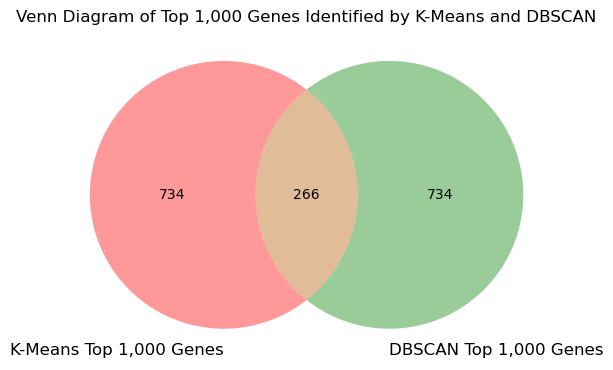

In [64]:
# Let's view the Venn diagram of the top 1000 genes found by each method 
k10_top1000_genes = set(k10_anova_results.head(1000)['Gene'])
dbscan_top1000_genes = set(dbscan_anova_results.head(1000)['Gene'])  

venn2(subsets = (k10_top1000_genes, dbscan_top1000_genes), set_labels = ('K-Means Top 1,000 Genes', 'DBSCAN Top 1,000 Genes'))

plt.title("Venn Diagram of Top 1,000 Genes Identified by K-Means and DBSCAN")
plt.show()

Interestingly, the majority of influential genes for one clustering method is not shared with the other clustering method.

## Most important features (genes) per tissue <a class="anchor" id="tissue_genes"></a>

For each tissue:

1. I will perform Welch's independent t-test to compare the expression of each gene in this tissue vs. all other tissues (p value for significance). 
2. I will perform the Benjamini-Hochberg procedure to control the false discovery rate (q value).
3. I will compute the difference of mean values of each gene's value in this tissue vs. all other tissues. A descriptor like log2 fold change would not apply here, as the data is already scaled.

In [65]:
# Define function to compute tissue-specific markers
def compute_tissue_markers(
        data_raw,
        tissue_labels='Tissue',
        alpha=0.05,
):
    # Define expression matrix, gene names, and tissue labels
    expr = data_raw.drop(columns=[tissue_labels])
    genes = expr.columns
    tissues = data_raw[tissue_labels]
    tissues_unique = tissues.unique()

    # Initialize empty list to store per-tissue marker results
    markers_per_tissue = [] 

    for tissue in tissues_unique:
        # Create binary True/False labels for the current tissue
        mask_tissue = (tissues == tissue)
        mask_rest = ~mask_tissue

        # Get samples in this tissue
        samples_tissue = expr[mask_tissue]
        # Get all the rest of the samples
        samples_rest = expr[mask_rest]

        # Run t-test (Welch, unequal variances)
        _, p_vals = ttest_ind(
            samples_tissue,
            samples_rest,
            axis=0, # column-wise comparison (columns are genes)
            equal_var=False, # Welch's t-test
            nan_policy='omit'
            )
        
        # Adjust p-values using Benjamini-Hochberg FDR correction
        _, q_vals, _, _ = multipletests(p_vals, alpha=alpha, method='fdr_bh')

        # Find the means of each gene in tissue vs rest
        mean_tissue = samples_tissue.mean(axis=0)
        mean_rest = samples_rest.mean(axis=0)

        # Find the difference in means
        diff_means = mean_tissue - mean_rest

        # Build a per-tissue dataframe of results
        tissue_markers = pd.DataFrame({
            'Tissue': tissue,
            'Gene': genes,
            'Mean in Tissue': mean_tissue.values,
            'Mean in Rest': mean_rest.values,
            'Difference in Means': diff_means.values,
            'Difference in Means (absolute)': np.abs(diff_means.values),
            'P-Value (uncorrected)': p_vals,
            'Q-Value (after BH correction)': q_vals
        })

        markers_per_tissue.append(tissue_markers)
    
    return pd.concat(markers_per_tissue, ignore_index=True)


# Execute function to compute tissue-specific markers
tissue_markers = compute_tissue_markers(data_raw)

tissue_markers.head()


,Tissue,Gene,Mean in Tissue,Mean in Rest,Difference in Means,Difference in Means (absolute),P-Value (uncorrected),Q-Value (after BH correction)
0,Adipose - Subcutaneous,ENSG00000244734.3,-0.317560,0.036250,-0.353810,0.353810,8.352840e-138,3.828066e-137
1,Adipose - Subcutaneous,ENSG00000188536.12,-0.319184,0.036436,-0.355619,0.355619,3.544200e-139,1.645404e-138
2,Adipose - Subcutaneous,ENSG00000198804.2,-0.245941,0.028075,-0.274016,0.274016,8.070738e-43,1.462090e-42
3,Adipose - Subcutaneous,ENSG00000198938.2,0.262739,-0.029992,0.292732,0.292732,7.062390e-28,1.111487e-27
4,Adipose - Subcutaneous,ENSG00000163220.10,-0.269843,0.030803,-0.300647,0.300647,5.275327e-101,1.648540e-100


Now I will create separate dataframes for each tissue. I will filter out genes whose q-value is >= 0.05, then sort by absolute value of mean difference.

In [66]:
# Create dictionary: split into separate DataFrames by tissue
markers_by_tissue = {
    tissue: df.reset_index(drop=True)
    for tissue, df in tissue_markers.groupby("Tissue")
}

In [67]:
# Initiate empty dictionary to hold filtered and sorted dataframes
filtered_sorted_by_tissue = {}

for tissue, df in markers_by_tissue.items():
    df_filtered = df[df["Q-Value (after BH correction)"] < 0.05]
    df_sorted = df_filtered.sort_values(
        by="Difference in Means (absolute)",
        ascending=False
    ).drop(columns=['Tissue', 'Mean in Tissue', 'Mean in Rest', 'Difference in Means (absolute)', 'P-Value (uncorrected)'])
    filtered_sorted_by_tissue[tissue] = df_sorted.reset_index(drop=True)

In [68]:
# Print the top 10 markers for each tissue

unique_tissues = tissue_markers['Tissue'].unique()

for tissue in unique_tissues:
    print(f"Top 10 markers for tissue: {tissue}")
    display(filtered_sorted_by_tissue[tissue].head(10))

Top 10 markers for tissue: Adipose - Subcutaneous


,Gene,Difference in Means,Q-Value (after BH correction)
0,ENSG00000132170.19,2.835594,2.434205e-234
1,ENSG00000135218.17,2.773504,8.558432e-220
2,ENSG00000166819.11,2.699742,1.123184e-175
3,ENSG00000161649.12,2.699673,4.718459e-184
4,ENSG00000165269.12,2.655322,1.816853e-187
5,ENSG00000177666.16,2.648198,9.597784e-177
6,ENSG00000170323.8,2.642475,3.360515e-163
7,ENSG00000186642.15,2.631070,8.396012e-242
8,ENSG00000187288.10,2.615103,1.057059e-157
9,ENSG00000167676.4,2.589428,6.763150e-159


Top 10 markers for tissue: Muscle - Skeletal


,Gene,Difference in Means,Q-Value (after BH correction)
0,ENSG00000167476.10,2.854217,0.0
1,ENSG00000239474.6,2.846373,0.0
2,ENSG00000196091.13,2.846288,0.0
3,ENSG00000079393.20,2.843846,0.0
4,ENSG00000143164.15,2.843345,0.0
5,ENSG00000196218.12,2.842943,0.0
6,ENSG00000136717.14,2.838957,0.0
7,ENSG00000104879.4,2.838698,0.0
8,ENSG00000185482.7,2.820188,0.0
9,ENSG00000125744.11,2.805320,0.0


Top 10 markers for tissue: Artery - Tibial


,Gene,Difference in Means,Q-Value (after BH correction)
0,ENSG00000145936.8,3.088101,0.000000e+00
1,ENSG00000162458.12,3.077545,0.000000e+00
2,ENSG00000049323.15,3.065687,0.000000e+00
3,ENSG00000174099.10,3.039680,0.000000e+00
4,ENSG00000197380.10,3.039491,1.479855e-318
5,ENSG00000072952.18,3.028200,0.000000e+00
6,ENSG00000125868.15,3.027855,1.850614e-306
7,ENSG00000101335.9,3.017733,2.891734e-299
8,ENSG00000196924.14,3.013006,3.457287e-310
9,ENSG00000162267.12,3.012041,2.047315e-308


Top 10 markers for tissue: Skin - Not Sun Exposed (Suprapubic)


,Gene,Difference in Means,Q-Value (after BH correction)
0,ENSG00000189182.9,2.445554,6.758081e-190
1,ENSG00000074410.13,2.315607,6.725134e-264
2,ENSG00000149527.17,2.315175,1.158055e-241
3,ENSG00000177508.11,2.305814,1.061681e-227
4,ENSG00000114270.17,2.301242,1.096705e-206
5,ENSG00000168490.13,2.286186,8.235468e-163
6,ENSG00000167695.14,2.243260,3.204447e-261
7,ENSG00000115884.10,2.237937,0.000000e+00
8,ENSG00000171346.15,2.223255,2.845862e-190
9,ENSG00000189334.8,2.217731,5.447049e-293


Top 10 markers for tissue: Thyroid


,Gene,Difference in Means,Q-Value (after BH correction)
0,ENSG00000125618.16,3.128616,0.000000e+00
1,ENSG00000165409.16,3.119457,1.167809e-317
2,ENSG00000205517.12,3.084710,0.000000e+00
3,ENSG00000255794.7,3.070566,8.778566e-288
4,ENSG00000185133.13,3.061205,4.216839e-283
5,ENSG00000054690.13,3.045684,3.905357e-282
6,ENSG00000137364.4,3.028156,5.592820e-281
7,ENSG00000259104.2,3.008132,3.006592e-257
8,ENSG00000100084.14,3.006862,4.878993e-282
9,ENSG00000140263.13,3.005242,1.411030e-278


Top 10 markers for tissue: Lung


,Gene,Difference in Means,Q-Value (after BH correction)
0,ENSG00000225383.7,3.050137,5.256062e-188
1,ENSG00000118526.6,3.018920,3.143330e-180
2,ENSG00000160867.14,3.017253,9.063742e-182
3,ENSG00000198682.12,3.006807,1.678615e-240
4,ENSG00000162545.5,2.914377,6.133672e-182
5,ENSG00000204305.13,2.899016,8.372170e-157
6,ENSG00000241644.2,2.894356,1.510302e-169
7,ENSG00000145506.13,2.893362,1.016817e-170
8,ENSG00000196260.4,2.879944,4.574497e-150
9,ENSG00000175899.14,2.874005,2.405317e-213


Top 10 markers for tissue: Nerve - Tibial


,Gene,Difference in Means,Q-Value (after BH correction)
0,ENSG00000105559.11,3.191435,4.720961e-312
1,ENSG00000165868.13,3.160495,3.940273e-307
2,ENSG00000230798.5,3.155609,2.691561e-279
3,ENSG00000172005.10,3.142858,2.484057e-283
4,ENSG00000005513.9,3.142083,2.395438e-293
5,ENSG00000219438.8,3.138083,7.939669e-274
6,ENSG00000064787.13,3.132807,8.584702e-268
7,ENSG00000241404.6,3.130416,4.260665e-297
8,ENSG00000012171.19,3.116190,1.027833e-287
9,ENSG00000261857.6,3.108035,4.634438e-261


Top 10 markers for tissue: Skin - Sun Exposed (Lower leg)


,Gene,Difference in Means,Q-Value (after BH correction)
0,ENSG00000283992.1,2.436133,6.867655e-253
1,ENSG00000179859.9,2.416352,3.297595e-283
2,ENSG00000143631.10,2.413688,7.690695e-207
3,ENSG00000172867.3,2.393906,4.665932e-155
4,ENSG00000165953.9,2.390063,1.897087e-266
5,ENSG00000136695.14,2.376772,2.963851e-230
6,ENSG00000126233.1,2.376116,1.097137e-231
7,ENSG00000178585.14,2.369827,3.034257e-311
8,ENSG00000203786.6,2.356179,2.073841e-179
9,ENSG00000204539.3,2.315765,6.507407e-196


Top 10 markers for tissue: Heart - Left Ventricle


,Gene,Difference in Means,Q-Value (after BH correction)
0,ENSG00000118194.18,3.528250,4.169211e-147
1,ENSG00000183072.9,3.403393,1.266338e-126
2,ENSG00000134571.10,3.399952,5.088478e-126
3,ENSG00000114923.16,3.393628,1.824774e-127
4,ENSG00000129991.12,3.387364,4.214961e-124
5,ENSG00000105409.16,3.204113,4.140577e-102
6,ENSG00000121577.13,3.165953,6.714409e-109
7,ENSG00000170558.8,3.133445,4.210918e-99
8,ENSG00000103034.14,3.107534,1.359285e-108
9,ENSG00000078114.18,3.065334,6.970631e-102


Top 10 markers for tissue: Whole Blood


,Gene,Difference in Means,Q-Value (after BH correction)
0,ENSG00000198858.9,2.847319,0.000000e+00
1,ENSG00000128340.14,2.784106,2.302167e-285
2,ENSG00000147454.13,2.741394,3.633003e-273
3,ENSG00000104894.11,2.734773,4.902625e-287
4,ENSG00000162511.7,2.707627,2.038242e-273
5,ENSG00000188536.12,2.703860,4.331423e-247
6,ENSG00000130830.14,2.703644,1.477211e-292
7,ENSG00000141480.17,2.698125,4.833148e-258
8,ENSG00000244734.3,2.695119,8.483422e-244
9,ENSG00000136167.13,2.690542,2.200969e-246


## Most important features (genes) driving clustering and per tissue <a class="anchor" id="cluster_vs_tissue"></a>

Let's compare the top 1000 genes found by each clustering method to the most important marker genes per tissue, using a Venn diagram


In [69]:
# First, get unique significant genes across all tissues
significant_genes_tissues = set()

for tissue, df in filtered_sorted_by_tissue.items():
    significant_genes_tissues.update(df["Gene"].unique())

print(f"Total unique significant genes across all tissues: {len(significant_genes_tissues)}")

Total unique significant genes across all tissues: 4990


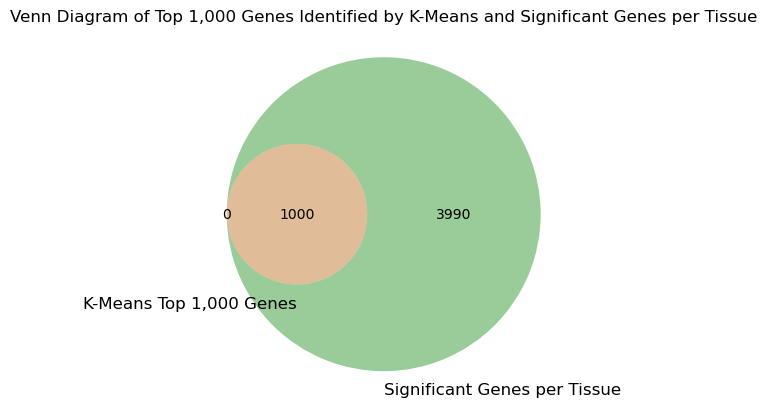

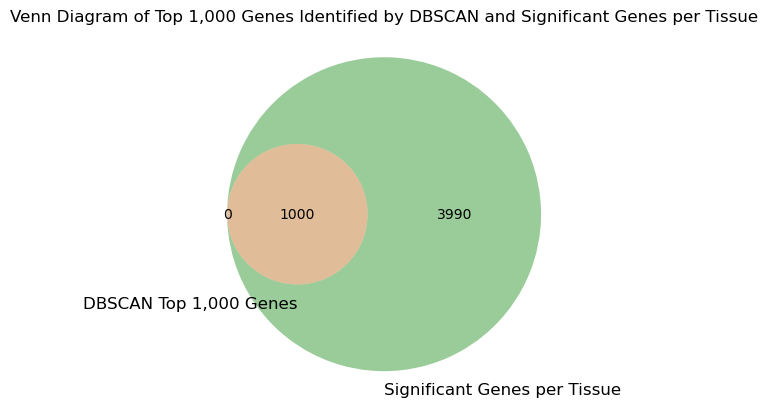

In [70]:

# Now make a Venn diagram compared to the top 1000 genes in k-means clustering, as identified by ANOVA above
venn2(subsets = (k10_top1000_genes, significant_genes_tissues),
      set_labels = ('K-Means Top 1,000 Genes', 'Significant Genes per Tissue'))
plt.title("Venn Diagram of Top 1,000 Genes Identified by K-Means and Significant Genes per Tissue")
plt.show()

# And make a Venn diagram compared to the top 1000 genes in DBSCAN clustering, as identified by ANOVA above
venn2(subsets = (dbscan_top1000_genes, significant_genes_tissues),
      set_labels = ('DBSCAN Top 1,000 Genes', 'Significant Genes per Tissue'))
plt.title("Venn Diagram of Top 1,000 Genes Identified by DBSCAN and Significant Genes per Tissue")
plt.show()


Interestingly, all of the top 1,000 genes identified by both k-means and DBSCAN clustering appear in the significant marker genes identified per tisue.